# Bank Marketing Classification Project

L'obiettivo di questo progetto è di prevedere se un cliente sottoscriverà un deposito a termine sulla base di varie caratteristiche del dataset "Bank Marketing".

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Caricamento del dataset

In [82]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bank Marketing/bank-additional-full.csv", sep=';', na_values=['NA'])

## Descrizione delle variabili
## bank client data:
1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
## related with the last contact of the current campaign:<br>
8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
## other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
## social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric) <br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

## Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')<br>

---------

Questa descrizione delle variabili è fornita dal sito in cui è stato reperito il dataset (https://archive.ics.uci.edu/dataset/222/bank+marketing)

In [83]:
# Rimozione della colonna 'duration' (non utile per la predizione come suggerito dalle informazioni del dataset)
df = df.drop('duration', axis=1)

In [84]:
# Gesione di pdays
def categorize_pdays(pdays):
    if pdays == 999:
        return "Never contacted"
    elif pdays <= 30:
        return "Recently contacted"
    else:
        return "Contacted long ago"

df['pdays_category'] = df['pdays'].apply(categorize_pdays)
df = df.drop('pdays', axis=1)

In [85]:
# Esplorazione iniziale
df.shape

(41188, 20)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  previous        41188 non-null  int64  
 12  poutcome        41188 non-null  object 
 13  emp.var.rate    41188 non-null  float64
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  euribor3m       41188 non-null  float64
 17  nr.employed     41188 non-null 

__Osservazione:__  
    Il dataset non presenta valori nulli/nan/mancanti.

In [87]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_category
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Never contacted
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Never contacted
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Never contacted
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Never contacted
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Never contacted


## Analisi della variabile target

y
no     36548
yes     4640
Name: count, dtype: int64


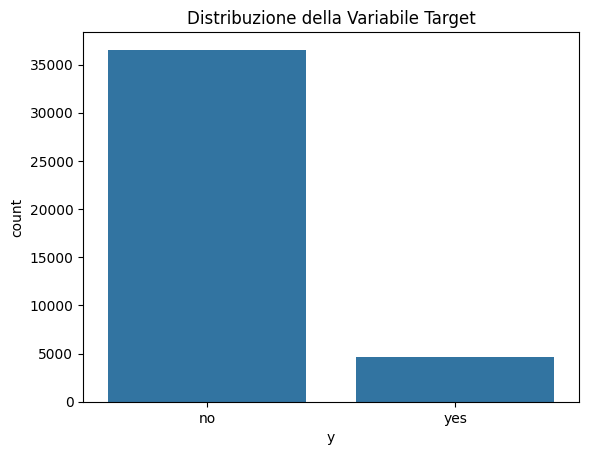

In [88]:
print(df.y.value_counts())
sns.countplot(x='y', data=df)
plt.title('Distribuzione della Variabile Target')
plt.show()

__Osservazione:__  
Il dataset è fortemente sbilanciato.

## Features categoriche

In [89]:
categorical_cols = list(df.select_dtypes(include=['object']))
categorical_cols.remove('y')

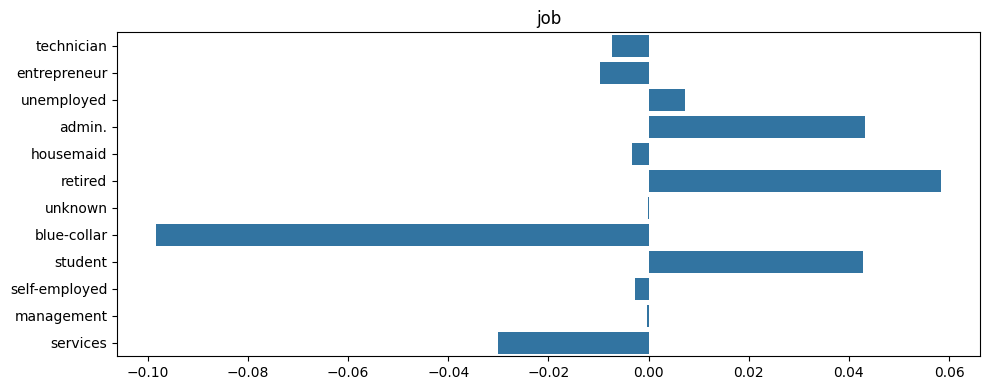

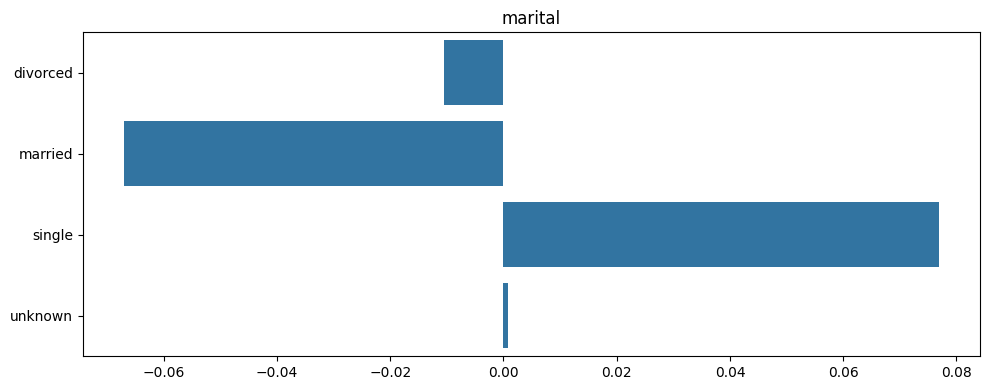

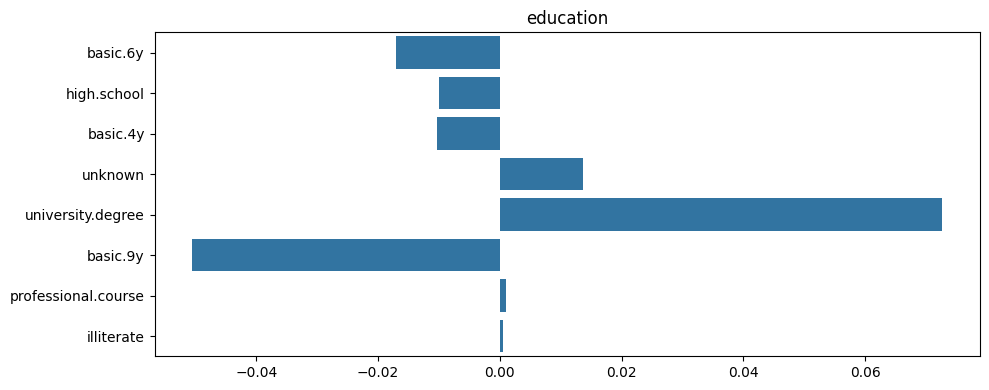

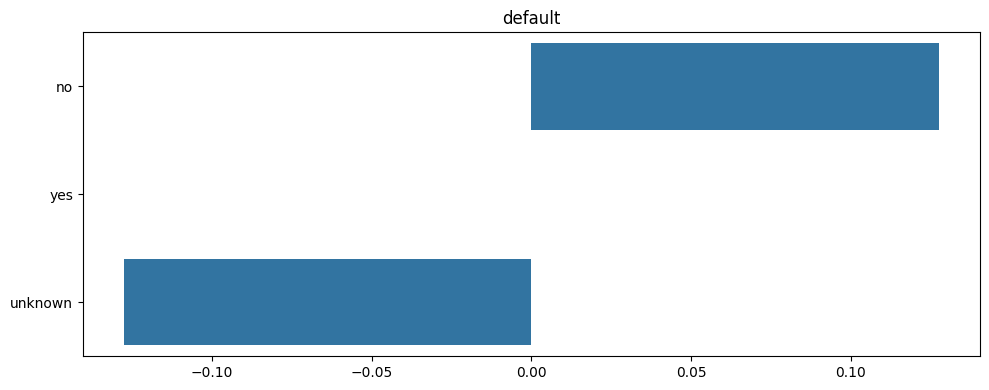

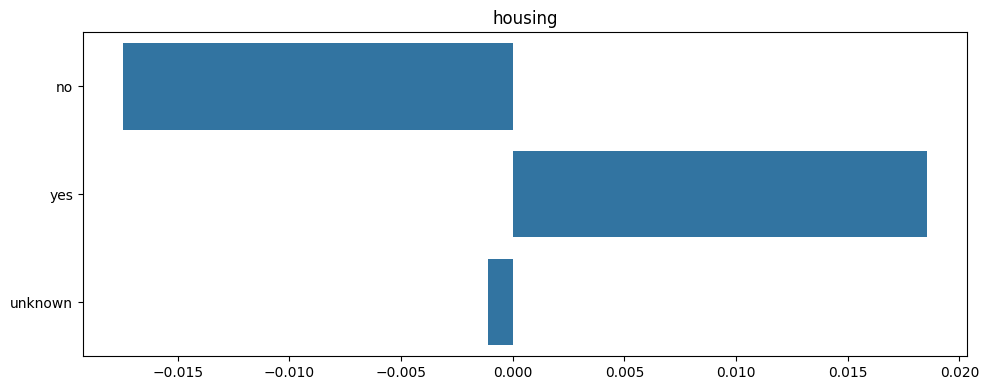

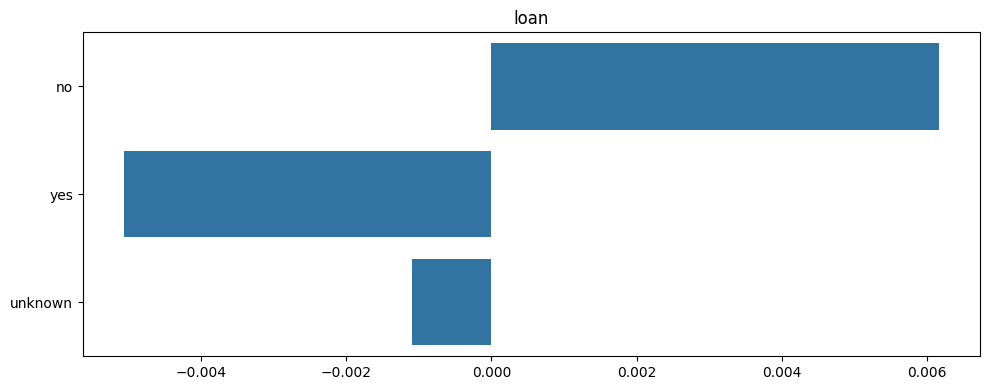

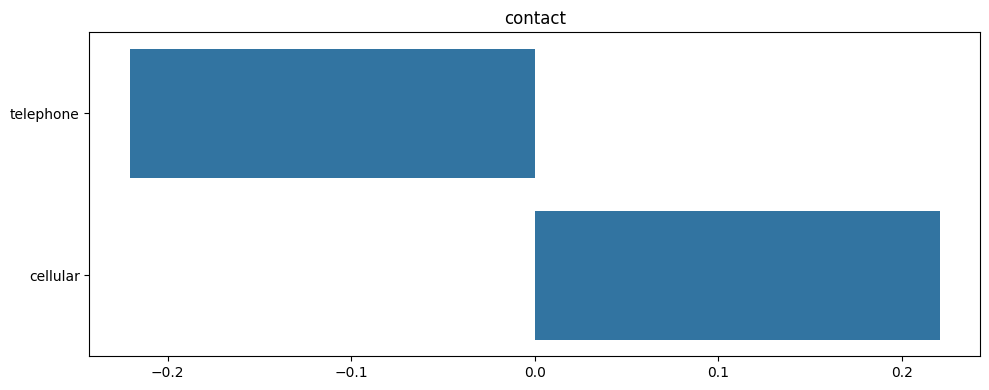

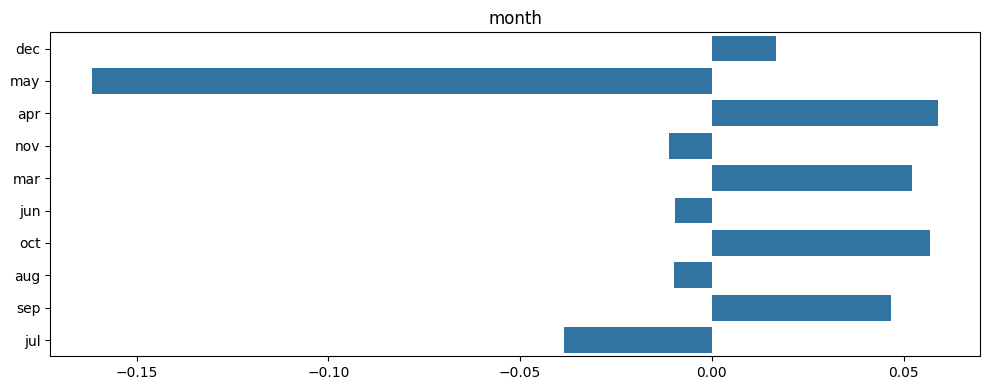

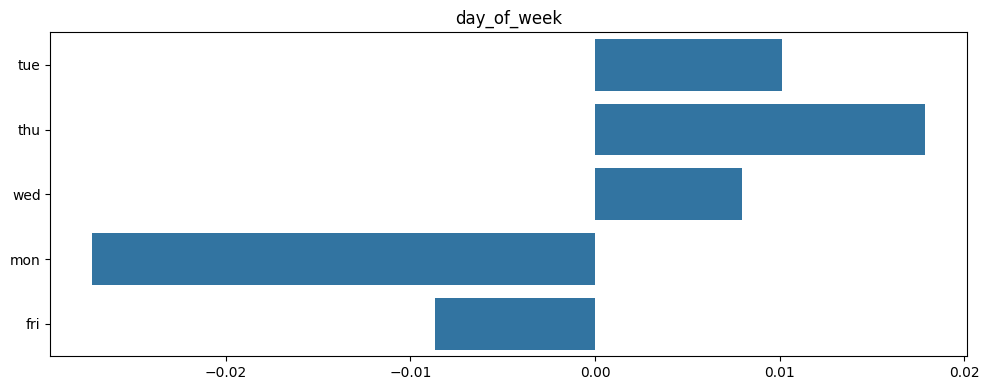

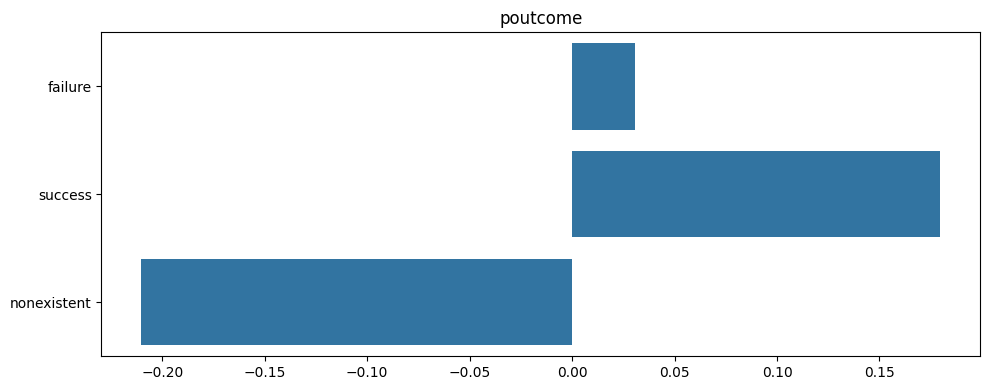

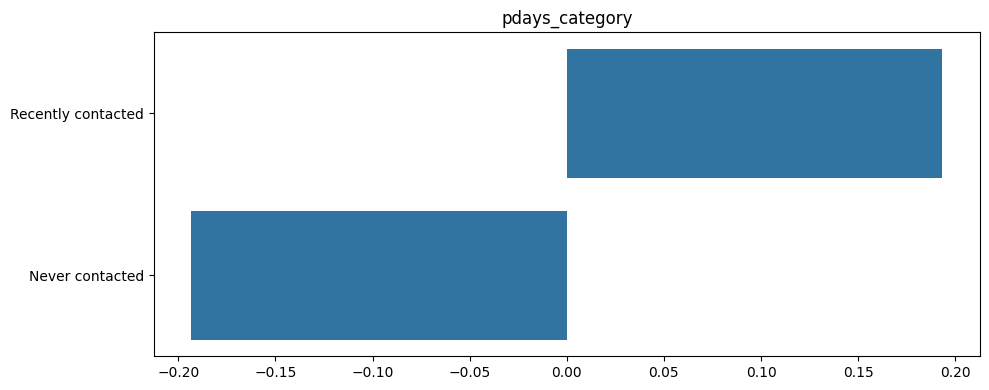

In [90]:
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    # Conteggio dei valori univoci per ogni risultato per ogni feature
    pos_counts = df.loc[df.y.values == 'yes', col].value_counts()
    neg_counts = df.loc[df.y.values == 'no', col].value_counts()

    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))

    # Conteggio della frequenza con cui è stato registrato ciascun risultato
    freq_pos = (df.y.values == 'yes').sum()
    freq_neg = (df.y.values == 'no').sum()

    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()

    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(x=all_counts, y=all_index)
    plt.title(col)
    plt.tight_layout()

In [91]:
df = df[df.job != 'unknown']
df = df[df.marital != 'unknown']
df = df[df.education != 'illiterate']
df = df[df.default != 'yes']
df = df[df.housing != 'unknown']

## Features numeriche

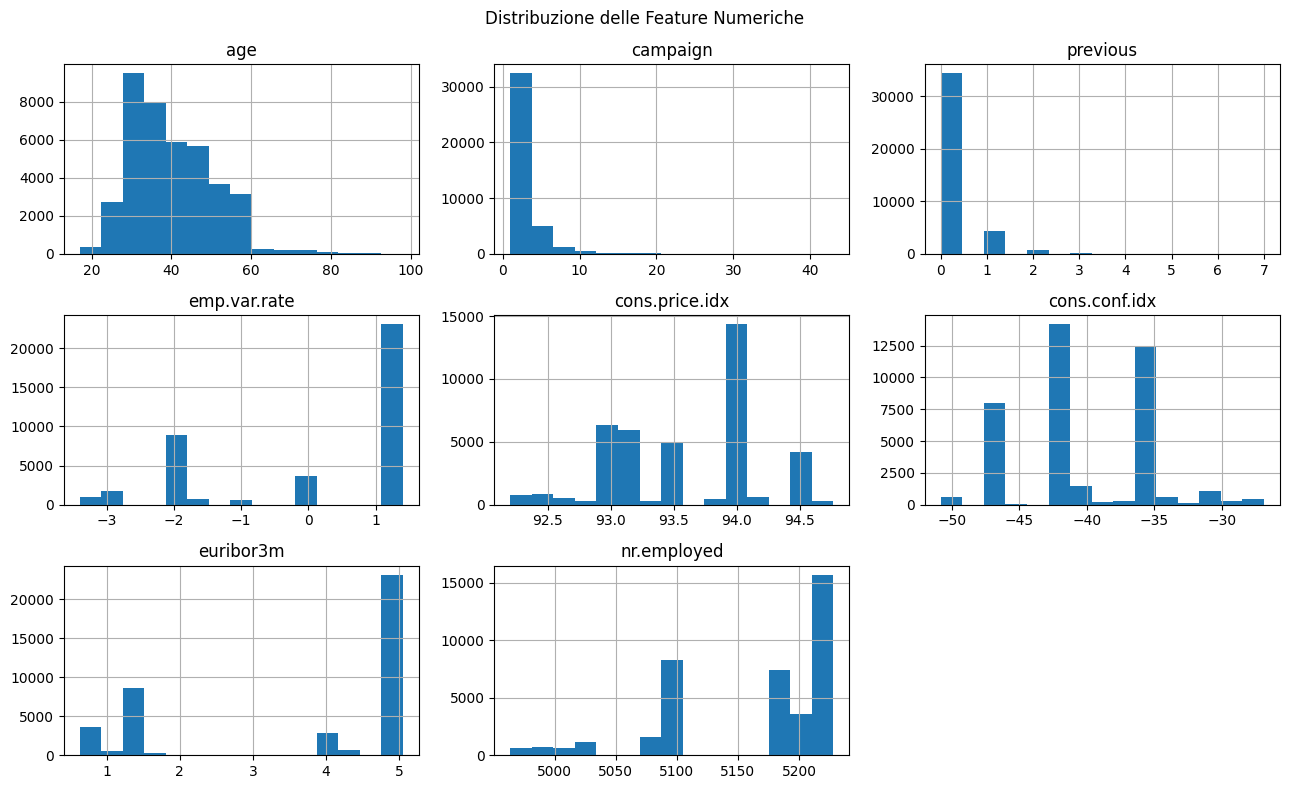

In [92]:
numerical_cols = list(df.select_dtypes(exclude=['object']))
num_cols = len(numerical_cols)
num_rows = (num_cols + 2) // 3

df[numerical_cols].hist(bins=15, figsize=(13, 8), layout=(num_rows, 3))
plt.suptitle('Distribuzione delle Feature Numeriche')
plt.tight_layout()
plt.show()

## Identificazione e gestione degli outlier

In [93]:
def handle_outliers(df, numerical_cols):
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

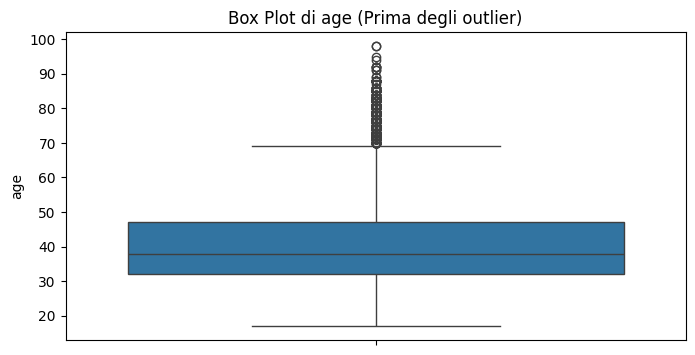

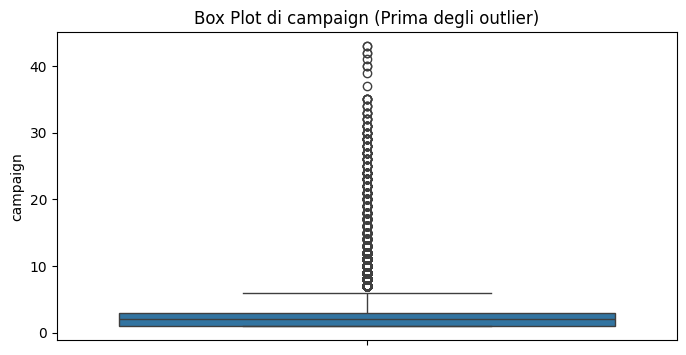

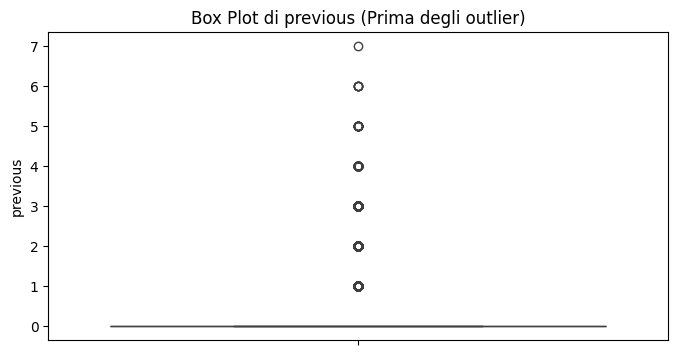

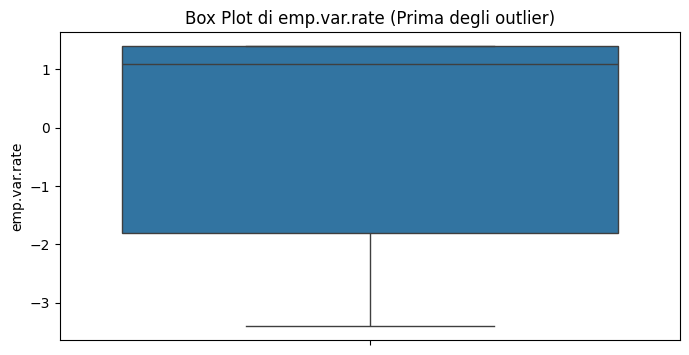

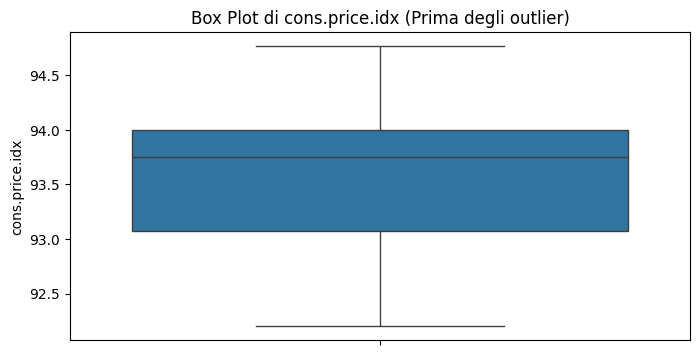

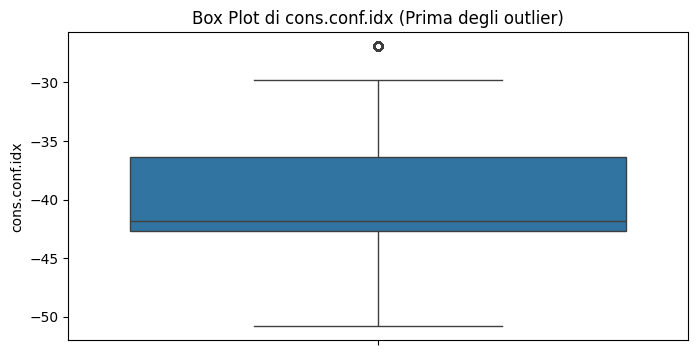

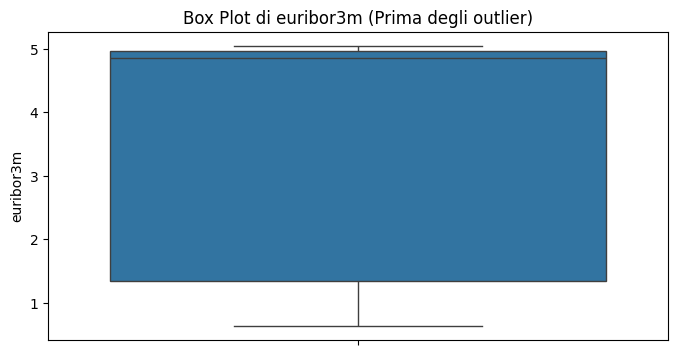

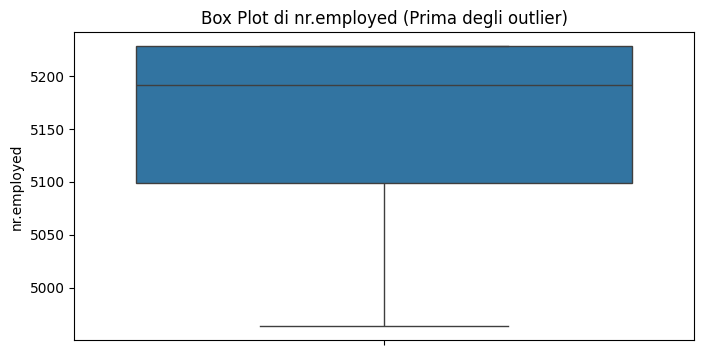

In [94]:
# Prima degli outlier
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot di {col} (Prima degli outlier)')
    plt.show()

In [95]:
# Gestione outlier
df = handle_outliers(df, numerical_cols)

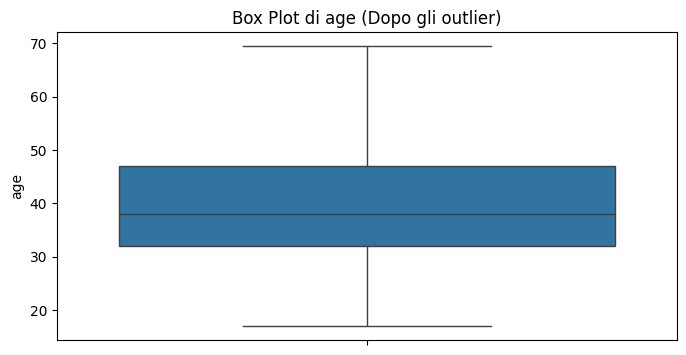

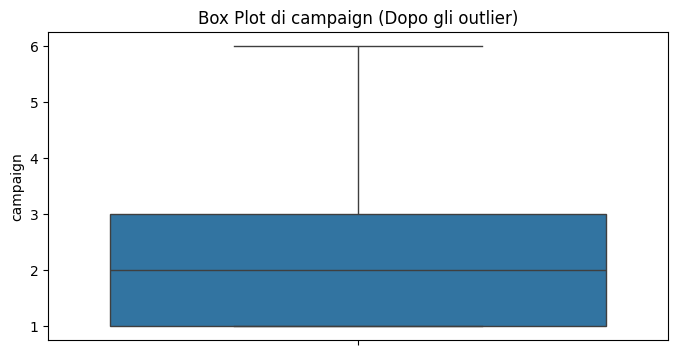

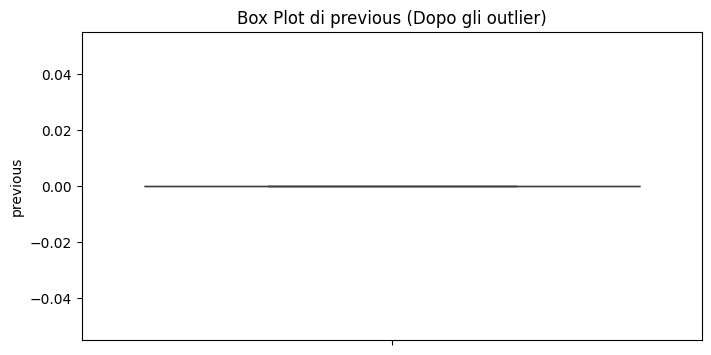

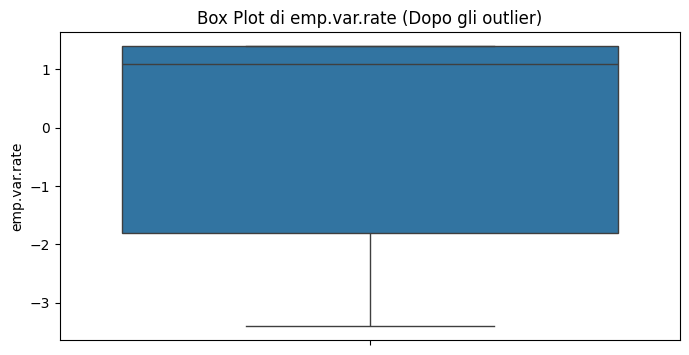

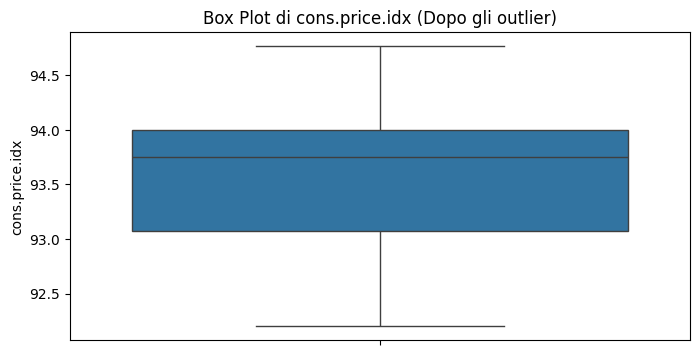

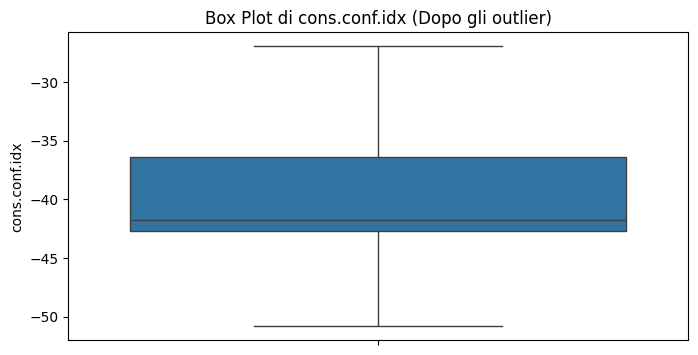

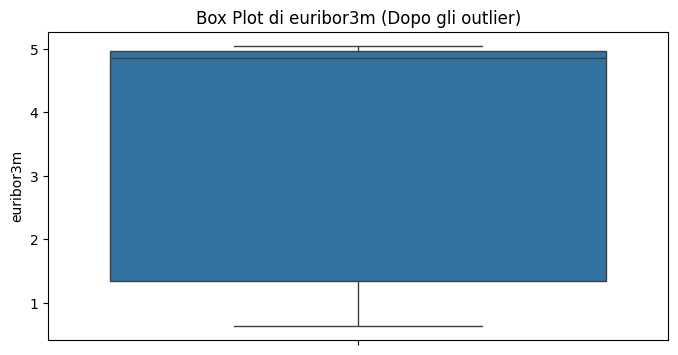

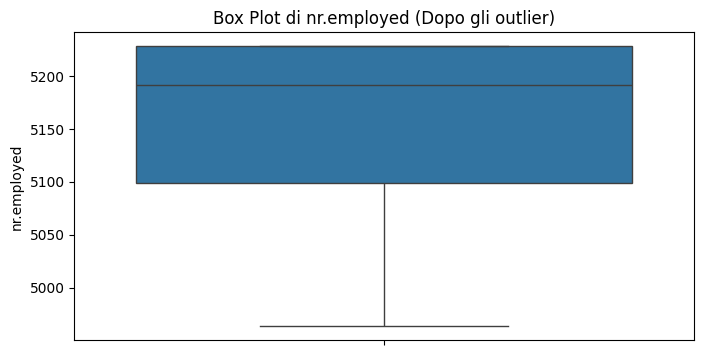

In [96]:
# Dopo gli outlier
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot di {col} (Dopo gli outlier)')
    plt.show()

## Dummificazione variabili categoriche

In [97]:
df = pd.get_dummies(df, columns=categorical_cols)
dummy_cols = [col for col in df.columns if col not in numerical_cols + ['y']]
print(df.head(10))

    age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0  56.0       1.0       0.0           1.1          93.994          -36.4   
1  57.0       1.0       0.0           1.1          93.994          -36.4   
2  37.0       1.0       0.0           1.1          93.994          -36.4   
3  40.0       1.0       0.0           1.1          93.994          -36.4   
4  56.0       1.0       0.0           1.1          93.994          -36.4   
5  45.0       1.0       0.0           1.1          93.994          -36.4   
6  59.0       1.0       0.0           1.1          93.994          -36.4   
7  41.0       1.0       0.0           1.1          93.994          -36.4   
8  24.0       1.0       0.0           1.1          93.994          -36.4   
9  25.0       1.0       0.0           1.1          93.994          -36.4   

   euribor3m  nr.employed   y  job_admin.  ...  day_of_week_fri  \
0      4.857       5191.0  no       False  ...            False   
1      4.857       5191.0  no

## Visualizzazione della correlazione e rimozione delle feature ridondanti

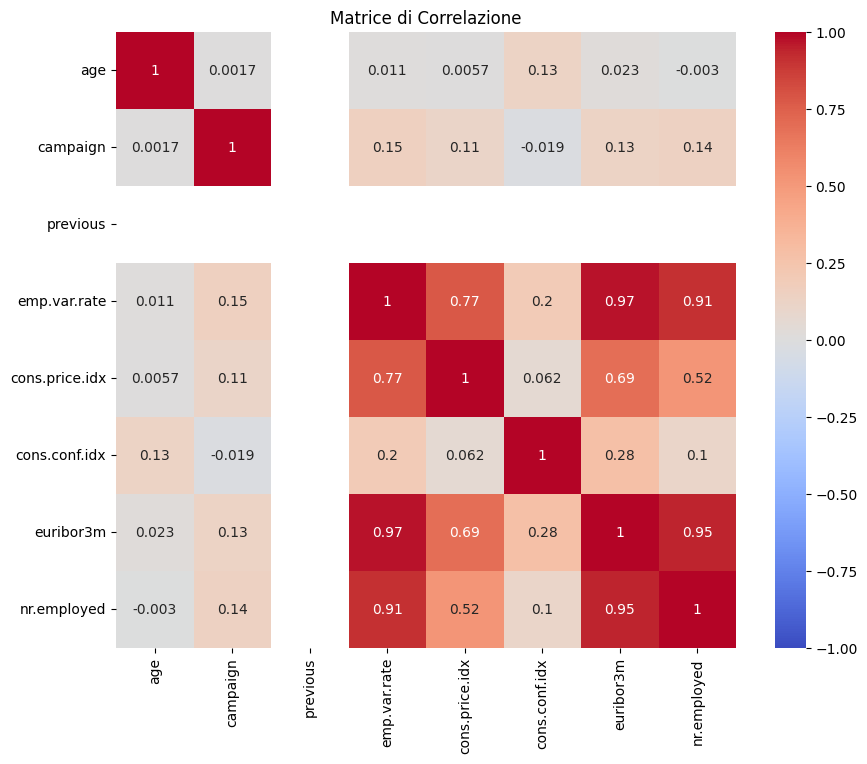

In [98]:
# Calcola la matrice di correlazione
corr_matrix = df[numerical_cols].corr()

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di Correlazione")
plt.show()

In [99]:
threshold = 0.8
upper_tri = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

print(f"Feature altamente correlate da rimuovere: {to_drop}")
df = df.drop(to_drop, axis=1)

Feature altamente correlate da rimuovere: ['euribor3m', 'nr.employed']


In [100]:
numerical_cols = list(df.select_dtypes(include=['float64']))

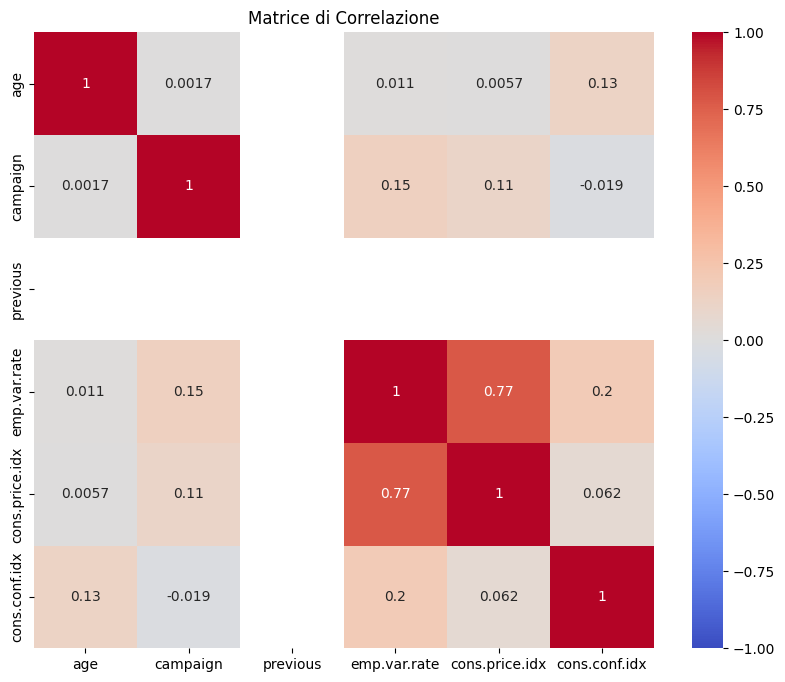

In [101]:
# Calcola la matrice di correlazione
corr_matrix = df[numerical_cols].corr()

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice di Correlazione")
plt.show()

## Normalizzazione / Scaling

In [102]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

## Risultato finale EDA

In [103]:
print(f'Shape finale del dataset: {df.shape}')
print(df.head())

Shape finale del dataset: (39782, 56)
        age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0  1.593617 -0.822841       0.0       0.64996        0.727815       0.890975   
1  1.692548 -0.822841       0.0       0.64996        0.727815       0.890975   
2 -0.286077 -0.822841       0.0       0.64996        0.727815       0.890975   
3  0.010717 -0.822841       0.0       0.64996        0.727815       0.890975   
4  1.593617 -0.822841       0.0       0.64996        0.727815       0.890975   

    y  job_admin.  job_blue-collar  job_entrepreneur  ...  day_of_week_fri  \
0  no       False            False             False  ...            False   
1  no       False            False             False  ...            False   
2  no       False            False             False  ...            False   
3  no        True            False             False  ...            False   
4  no       False            False             False  ...            False   

   day_of_we

# Classificazione

## Inizializzazione

In [104]:
# Divisione del dataset in train set e test set
df['y'] = df['y'].map({'yes': 1, 'no': 0})
y = df['y'].values
X = df.drop('y', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify=y)

In [105]:
# Funzioni di Model Evaluation
def model_scores(y_test, y_pred, y_pred_proba, show_plot):
    # Converte le labels delle stringhe in numeri se necessario
    if isinstance(y_test[0], str):
        y_test = LabelEncoder().fit_transform(y_test)
    if isinstance(y_pred[0], str):
        y_pred = LabelEncoder().fit_transform(y_pred)

    print('Confusion matrix :\n', confusion_matrix(y_test, y_pred))
    print('Accuracy :', accuracy_score(y_test, y_pred))
    print('AUC score :', roc_auc_score(y_test, y_pred_proba))
    print('F1-score :', f1_score(y_test, y_pred))
    print('Precision score :', precision_score(y_test, y_pred))
    print('Recall score :', recall_score(y_test, y_pred))
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr_test, tpr_test, label="ROC Curve")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    if show_plot:
        plt.show()

In [106]:
def model_evaluation(model, X_train, y_train, X_test, y_test, trained=False):
    if not trained:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    print('Train dataset :')
    model_scores(y_train, y_pred, y_pred_proba, show_plot=False)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print('\nTest dataset :')
    model_scores(y_test, y_pred, y_pred_proba, show_plot=True)

## Logistic Regression


##### LOGISTIC REGRESSION #####
Best parameters found:
 {'Cs': 10, 'cv': 5}
Train dataset :
Confusion matrix :
 [[27834   405]
 [ 2768   818]]
Accuracy : 0.9002985074626866
AUC score : 0.7937853615325183
F1-score : 0.34019546683302143
Precision score : 0.6688470973017171
Recall score : 0.22810931399888454

Test dataset :
Confusion matrix :
 [[6968   92]
 [ 697  200]]
Accuracy : 0.9008420258891542
AUC score : 0.7844360016548709
F1-score : 0.33641715727502103
Precision score : 0.684931506849315
Recall score : 0.2229654403567447


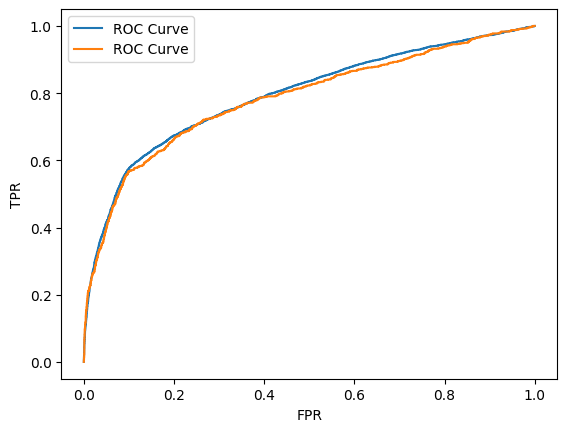

In [107]:
print("\n##### LOGISTIC REGRESSION #####")
log_reg = LogisticRegressionCV()
clf = GridSearchCV(log_reg, {'Cs': [1, 3, 5, 10], 'cv': [3, 5]}, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
print('Best parameters found:\n', clf.best_params_)
model_evaluation(clf, X_train, y_train, X_test, y_test, trained=True)

In [108]:
print("TRAINING LOGISTIC REGRESSION")
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, clf.predict(X_train))))
print(classification_report(y_train, clf.predict(X_train)))
cm = confusion_matrix(y_train, clf.predict(X_train))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TRAINING LOGISTIC REGRESSION
Training-set accuracy score: 0.9003
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28239
           1       0.67      0.23      0.34      3586

    accuracy                           0.90     31825
   macro avg       0.79      0.61      0.64     31825
weighted avg       0.88      0.90      0.88     31825

Confusion matrix

 [[27834   405]
 [ 2768   818]]

True Positives(TP) =  27834

True Negatives(TN) =  818

False Positives(FP) =  405

False Negatives(FN) =  2768


In [109]:
print("TEST LOGISTIC REGRESSION")
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, clf.predict(X_test))))
print(classification_report(y_test, clf.predict(X_test)))
cm = confusion_matrix(y_test, clf.predict(X_test))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TEST LOGISTIC REGRESSION
Test-set accuracy score: 0.9008
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7060
           1       0.68      0.22      0.34       897

    accuracy                           0.90      7957
   macro avg       0.80      0.60      0.64      7957
weighted avg       0.88      0.90      0.88      7957

Confusion matrix

 [[6968   92]
 [ 697  200]]

True Positives(TP) =  6968

True Negatives(TN) =  200

False Positives(FP) =  92

False Negatives(FN) =  697


## Oversampled Logistic Regression

In [110]:
# Sovracampionamento del dataset
smote = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Prima di SMOTE
print("\n=== Before SMOTE ===")
print("Original train shape:", X_train.shape, y_train.shape)
print(pd.Series(y_train).value_counts())

# Dopo SMOTE
print("\n=== After SMOTE ===")
print("Oversampled train shape:", X_train_sm.shape, y_train_sm.shape)
print(pd.Series(y_train_sm).value_counts())


=== Before SMOTE ===
Original train shape: (31825, 55) (31825,)
0    28239
1     3586
Name: count, dtype: int64

=== After SMOTE ===
Oversampled train shape: (56478, 55) (56478,)
0    28239
1    28239
Name: count, dtype: int64



##### LOGISTIC REGRESSION (oversampled data) #####
Best parameters found:
 {'Cs': 5, 'cv': 5}
Train dataset :
Confusion matrix :
 [[23817  4422]
 [10128 18111]]
Accuracy : 0.7423775629448635
AUC score : 0.8037028447897159
F1-score : 0.7134247222878752
Precision score : 0.8037544934096659
Recall score : 0.641347073196643

Test dataset :
Confusion matrix :
 [[5914 1146]
 [ 339  558]]
Accuracy : 0.8133718738217921
AUC score : 0.7830293613271813
F1-score : 0.4290657439446367
Precision score : 0.3274647887323944
Recall score : 0.6220735785953178


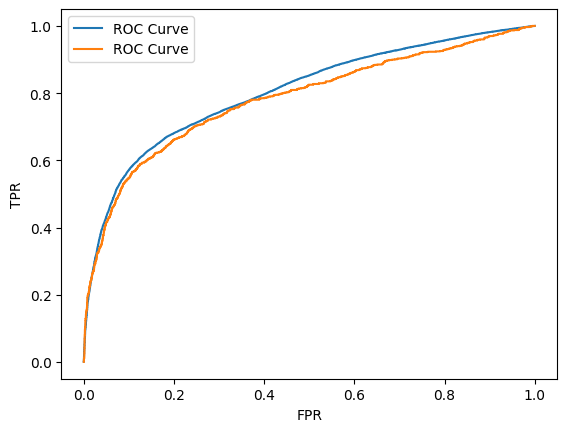

In [111]:
print("\n##### LOGISTIC REGRESSION (oversampled data) #####")
clf = GridSearchCV(log_reg, {'Cs': [1, 3, 5, 10], 'cv': [3, 5]}, n_jobs=-1, cv=5)
clf.fit(X_train_sm, y_train_sm)
print('Best parameters found:\n', clf.best_params_)
model_evaluation(clf, X_train_sm, y_train_sm, X_test, y_test, trained=True)

In [112]:
print("TRAINING LOGISTIC REGRESSION after SMOTE")
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train_sm, clf.predict(X_train_sm))))
print(classification_report(y_train_sm, clf.predict(X_train_sm)))
cm = confusion_matrix(y_train_sm, clf.predict(X_train_sm))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TRAINING LOGISTIC REGRESSION after SMOTE
Training-set accuracy score: 0.7424
              precision    recall  f1-score   support

           0       0.70      0.84      0.77     28239
           1       0.80      0.64      0.71     28239

    accuracy                           0.74     56478
   macro avg       0.75      0.74      0.74     56478
weighted avg       0.75      0.74      0.74     56478

Confusion matrix

 [[23817  4422]
 [10128 18111]]

True Positives(TP) =  23817

True Negatives(TN) =  18111

False Positives(FP) =  4422

False Negatives(FN) =  10128


In [113]:
print("\nTEST LOGISTIC REGRESSION after SMOTE")
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, clf.predict(X_test))))
print(classification_report(y_test, clf.predict(X_test)))
cm = confusion_matrix(y_test, clf.predict(X_test))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])


TEST LOGISTIC REGRESSION after SMOTE
Test-set accuracy score: 0.8134
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      7060
           1       0.33      0.62      0.43       897

    accuracy                           0.81      7957
   macro avg       0.64      0.73      0.66      7957
weighted avg       0.88      0.81      0.84      7957

Confusion matrix

 [[5914 1146]
 [ 339  558]]

True Positives(TP) =  5914

True Negatives(TN) =  558

False Positives(FP) =  1146

False Negatives(FN) =  339


## Neural Network

In [114]:
# Parametri della Neural Network
parameter_space = {
    'hidden_layer_sizes': [(8, 5), (7,), (10, 3), (30,), (50, 50, 50), (50, 100, 50), (100,)],
    'alpha': [0.0001, 0.1, 1, 3, 5],
    'learning_rate': ['constant', 'adaptive'],
}

In [115]:
# Ricerca parametri migliori
#mlp = MLPClassifier(max_iter=500)
#clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
#clf.fit(X_train, y_train)
# Set di parametri migliori
#print('Best parameters found:\n', clf.best_params_)
# {'alpha': 0.1, 'hidden_layer_sizes': (7,), 'learning_rate': 'constant'}


##### NEURAL NETWORKS #####
Train dataset :
Confusion matrix :
 [[27830   409]
 [ 2720   866]]
Accuracy : 0.9016810683424981
AUC score : 0.8065672043190734
F1-score : 0.3563052869779881
Precision score : 0.6792156862745098
Recall score : 0.241494701617401

Test dataset :
Confusion matrix :
 [[6959  101]
 [ 692  205]]
Accuracy : 0.9003393238657785
AUC score : 0.7847710814455487
F1-score : 0.3408146300914381
Precision score : 0.6699346405228758
Recall score : 0.22853957636566333


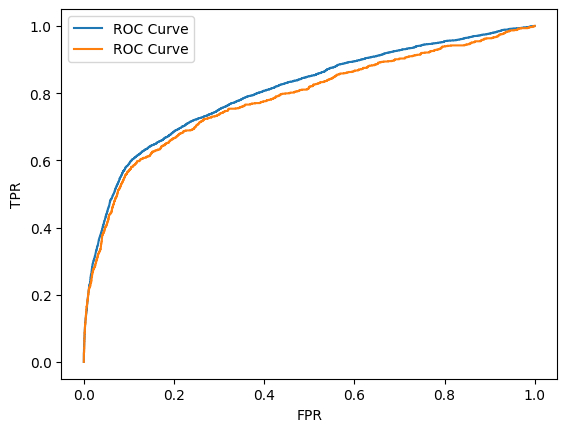

In [116]:
print("\n##### NEURAL NETWORKS #####")
mlp = MLPClassifier(max_iter=500, alpha=0.1, hidden_layer_sizes=(7,), learning_rate='constant')
model_evaluation(mlp, X_train, y_train, X_test, y_test, trained=False)

In [117]:
print("TRAINING NEURAL NETWORK")
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, mlp.predict(X_train))))
print(classification_report(y_train, mlp.predict(X_train)))
cm = confusion_matrix(y_train, mlp.predict(X_train))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TRAINING NEURAL NETWORK
Training-set accuracy score: 0.9017
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28239
           1       0.68      0.24      0.36      3586

    accuracy                           0.90     31825
   macro avg       0.80      0.61      0.65     31825
weighted avg       0.88      0.90      0.88     31825

Confusion matrix

 [[27830   409]
 [ 2720   866]]

True Positives(TP) =  27830

True Negatives(TN) =  866

False Positives(FP) =  409

False Negatives(FN) =  2720


In [118]:
print("TEST NEURAL NETWORK")
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, mlp.predict(X_test))))
print(classification_report(y_test, mlp.predict(X_test)))
cm = confusion_matrix(y_test, mlp.predict(X_test))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TEST NEURAL NETWORK
Test-set accuracy score: 0.9003
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7060
           1       0.67      0.23      0.34       897

    accuracy                           0.90      7957
   macro avg       0.79      0.61      0.64      7957
weighted avg       0.88      0.90      0.88      7957

Confusion matrix

 [[6959  101]
 [ 692  205]]

True Positives(TP) =  6959

True Negatives(TN) =  205

False Positives(FP) =  101

False Negatives(FN) =  692


## Oversampled NNs


##### NEURAL NETWORKS (oversampled data) #####
Train dataset :
Confusion matrix :
 [[26366  1873]
 [ 4003  5315]]
Accuracy : 0.8435444790584977
AUC score : 0.8524079519143852
F1-score : 0.6440082394280867
Precision score : 0.7394268224819143
Recall score : 0.5704013736853402

Test dataset :
Confusion matrix :
 [[6524  536]
 [ 454  443]]
Accuracy : 0.8755812492145281
AUC score : 0.7714784250934023
F1-score : 0.4722814498933902
Precision score : 0.4525025536261491
Recall score : 0.4938684503901895


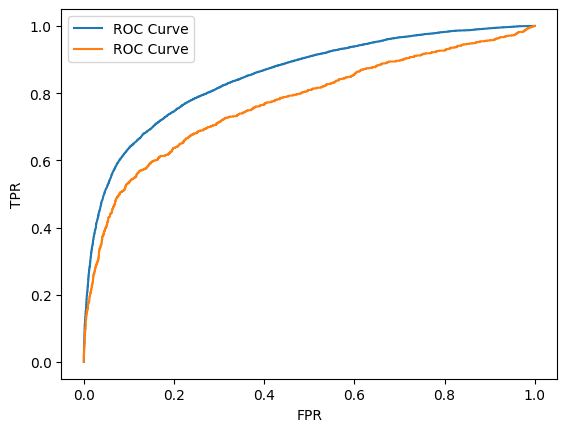

In [119]:
print("\n##### NEURAL NETWORKS (oversampled data) #####")
smote = SMOTE(sampling_strategy=0.33)
X_res, y_res = smote.fit_resample(X_train, y_train)
mlp = MLPClassifier(
    max_iter=1000,
    alpha=0.1,
    hidden_layer_sizes=(30, 15),
    early_stopping=True,
    validation_fraction=0.3,
    batch_size=512,
    solver='adam',
    activation='tanh',
    tol=1e-5,
    n_iter_no_change=20
)
model_evaluation(mlp, X_res, y_res, X_test, y_test, trained=False)

In [120]:
print("TRAINING NEURAL NETWORK after SMOTE")
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train_sm, mlp.predict(X_train_sm))))
print(classification_report(y_train_sm, mlp.predict(X_train_sm)))
cm = confusion_matrix(y_train_sm, mlp.predict(X_train_sm))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TRAINING NEURAL NETWORK after SMOTE
Training-set accuracy score: 0.7523
              precision    recall  f1-score   support

           0       0.69      0.93      0.79     28239
           1       0.90      0.57      0.70     28239

    accuracy                           0.75     56478
   macro avg       0.79      0.75      0.74     56478
weighted avg       0.79      0.75      0.74     56478

Confusion matrix

 [[26366  1873]
 [12117 16122]]

True Positives(TP) =  26366

True Negatives(TN) =  16122

False Positives(FP) =  1873

False Negatives(FN) =  12117


In [121]:
print("TEST NEURAL NETWORK after SMOTE")
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, mlp.predict(X_test))))
print(classification_report(y_test, mlp.predict(X_test)))
cm = confusion_matrix(y_test, mlp.predict(X_test))
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

TEST NEURAL NETWORK after SMOTE
Test-set accuracy score: 0.8756
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7060
           1       0.45      0.49      0.47       897

    accuracy                           0.88      7957
   macro avg       0.69      0.71      0.70      7957
weighted avg       0.88      0.88      0.88      7957

Confusion matrix

 [[6524  536]
 [ 454  443]]

True Positives(TP) =  6524

True Negatives(TN) =  443

False Positives(FP) =  536

False Negatives(FN) =  454
